In [74]:
from scipy.io import loadmat
import pandas as pd
import numpy as np
import math

In [75]:
mat = loadmat('data/kmeans.mat')
data = pd.DataFrame(mat['X'], columns=['x', 'y'])
del mat
data = data.sample(frac=1)
data.describe()

,x,y
count,300.000000,300.000000
mean,3.684376,2.987101
std,1.925578,1.685078
min,-0.245127,0.205810
25%,2.156202,1.210797
50%,3.231561,2.949738
75%,5.509490,4.807780
max,8.203398,5.784297


In [15]:
data.head()

,x,y
40,1.678380,5.269038
262,7.655032,2.870956
132,2.455759,0.789047
233,6.448344,3.352992
223,5.740362,3.103913


<AxesSubplot:xlabel='x', ylabel='y'>

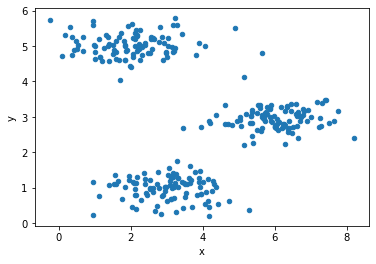

In [12]:
data.plot.scatter(x='x', y='y')

In [94]:
def find_nearest_cluster(data, index, mus):
    result = None
    result_cost = None
    for idx in range(0, len(mus)):
        v = mus[idx] - data.iloc[index]
        cost = np.dot(v, v)
        if result_cost is None or cost < result_cost:
            result = idx
            result_cost = cost

    return result, result_cost

def assign_cluster(data, mus):
    m = data.shape[0]
    result = []
    result_cost = 0
    
    for index in range(0, m):
        c, cost = find_nearest_cluster(data, index, mus)
        result.append(c)
        result_cost = result_cost + cost

    return result, result_cost / m

def select_mus(data, c, num_clusters):
    cluster_sum = [None] * num_clusters
    cluster_count = [0] * num_clusters
    m = data.shape[0]
    
    for i in range(0, m):
        selected_c = c[i]
        cluster_count[selected_c] = cluster_count[selected_c] + 1
        if cluster_sum[selected_c] is None:
            cluster_sum[selected_c] = data.iloc[i]
        else:
            cluster_sum[selected_c] = cluster_sum[selected_c] + data.iloc[i]
            
    mus = []
    for i in range(0, num_clusters):
        if cluster_count[i] == 0:
            return None, False
        mus.append(cluster_sum[i] / cluster_count[i])
        
    return mus, True

def iteration(data, mus):
    c, cost = assign_cluster(data, mus)
    mus, ok = select_mus(data, c, len(mus))
    return c, mus, cost, ok

def pick_initial_mus(data, num_clusters):
    arr = np.arange(0, data.shape[0])
    np.random.shuffle(arr)
    result = []
    for i in range(0, num_clusters):
        result.append(data.iloc[arr[i]])
    return result

def solve_once(data, num_clusters, sensitivity):
    c = None
    best_cost = None
    best_c = None
    mus = pick_initial_mus(data, num_clusters)
    
    while True:
        c, mus, cost, ok = iteration(data, mus)
        if not ok:
            return None, None, False
        if best_cost is None:
            best_cost = cost
            best_c = c
        else:
            if abs(best_cost - cost) < sensitivity:
                return best_c, best_cost, True
            if cost < best_cost:
                best_cost = cost
                best_c = c
                
def solve(data, num_clusters, retry, sensitivity):
    try_count = 0
    best_c = None
    best_cost = None
    while try_count <= retry:
        try_count = try_count + 1
        c, cost, ok = solve_once(data, num_clusters, sensitivity)
        if not ok:
            num_clusters = num_clusters - 1
            try_count = 0
            continue
        if best_c is None:
            best_c = c
            best_cost = cost
            try_count = 0
        elif abs(best_cost - cost) >= sensitivity and cost < best_cost:
            best_cost = cost
            best_c = c
            try_count = 0
            
    return best_c

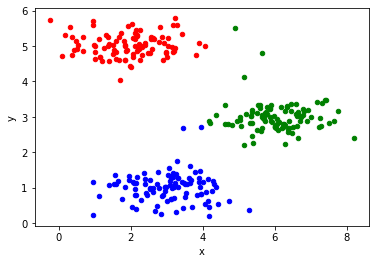

In [93]:
c = solve(data, 3, 1, 1e-5)
ax=data[ [x == 0 for x in c] ].plot.scatter(x='x', y='y', c='b')
ax=data[ [x == 1 for x in c] ].plot.scatter(x='x', y='y', c='g', ax=ax)
ax=data[ [x == 2 for x in c] ].plot.scatter(x='x', y='y', c='r', ax=ax)
ax=data[ [x == 3 for x in c] ].plot.scatter(x='x', y='y', c='orange', ax=ax)